# Desafio Luiza Labs

Este notebook tem dois objetivos principais: criar uma clusterização dos produtos vendidos pelo Magazine Luiza a partir do histórico de vendas destes e prever a venda de cada um dos produtos presentes no dataset para os meses de junho, julho e agosto.

Além disso, faz parte desse estudo a interpretação dos clusters criados e análise da qualidade das previsões feitas nas vendas de produtos.

As próximas seções estão divididas da seguinte forma: 

1. Análise exploratória dos dados
2. Clusterização
3. Previsão de vendas
4. Conclusões
5. Referências

## Análise exploratória dos dados

Nesta seção exploraremos as características básicas do dataset, não apenas suas dimensões mas também as características de suas variáveis. 

O dataset possui 179149 e 14 variáveis, das quais 8 variáveis são numéricas e 6 são categóricas. É interessante notar que todas as variáveis tem densidade de 100%, ou seja, elas contém valores em todas as células, deste modo, não será necessário usar técnicas de preenchimento de valores faltantes.  

Temos duas variáveis no dataset que são temporais, `capture_date` e `process_date`. A última contém alguns valores inadequados de data, **0000-00-00** que correspondem, em sua grande maioria, a pedidos que foram cancelados por algum motivo, tais como "cancelado boleto não pago" e "cancelado dados divergentes" ou suspeitas de fraude. Todas as células com o valor **0000-00-00** serão substituídas pelo valor `NaN`.  

In [364]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys


from matplotlib.ticker import FuncFormatter
from tmcm_feature_engineering import TMCMFeatureEng
from cluster_helper import plot_elbow_curve
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from datetime import datetime
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

BASE_DATA_PATH = "data/"
filename = "desafio.csv"
cancel_cols = [""]

def calculate_sparsity(df):
    sparsity_dict = {}
    for col in df.columns:
        sparsity_dict[col] = df[col].count()/df.shape[0]
    return(sparsity_dict)

In [5]:
df = pd.read_csv(BASE_DATA_PATH+filename)
df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


In [23]:
density_dict = calculate_sparsity(df)
sorted_density_list = sorted(density_dict.items(), key=lambda x: x[1])

for l in sorted_density_list:
    print("{:25} => Density of {:4.2f}%".format(l[0], l[1]*100))

category                  => Density of 100.00%
code                      => Density of 100.00%
order_id                  => Density of 100.00%
tax_substitution          => Density of 100.00%
price                     => Density of 100.00%
capture_date              => Density of 100.00%
process_status            => Density of 100.00%
order_status              => Density of 100.00%
icms                      => Density of 100.00%
pis_cofins                => Density of 100.00%
process_date              => Density of 100.00%
liquid_cost               => Density of 100.00%
source_channel            => Density of 100.00%
quantity                  => Density of 100.00%


In [5]:
filtered_df = df[df['process_date'] == "0000-00-00"]
grouped_filtered_df = filtered_df.groupby(['order_status']).agg({"order_id": "count"}).reset_index()
grouped_filtered_df.sort_values("order_id", ascending=False).head(15)

,order_status,order_id
1,cancelado boleto não pago,18425
0,cancelado,5274
2,cancelado dados divergentes,674
3,cancelado fraude confirmada,75
9,suspeita de fraude,31
7,fraude confirmada,5
8,pendente processamento,5
4,cancelado não aprovado,2
5,entrega parcial,1
6,entrega total,1


In [6]:
df['process_date'] = df['process_date'].apply(lambda x: np.nan if x == '0000-00-00' else x)
df['capture_date'] = pd.to_datetime(df['capture_date'], format="%Y/%m/%d")
df['process_date'] = pd.to_datetime(df['process_date'], format="%Y/%m/%d")

### Vendas e receita ao longo do tempo

Um dos objetivos desse estudo é prever a quantidade de vendas para cada um dos produtos. Dado isso, é importante ver como as vendas se comportam ao longo dos meses de maneiral geral. Abaixo serão feitas duas abordagens: uma considerando todos os dados independente da variável `order_status` e outra que desconsidera todas as vendas que de alguma forma estão relacionadas a cancelamentos ou fraudes. 

#### Todas as vendas

A partir dos gráficos abaixo é possível ver que existem dois picos de vendas de produtos, um deles no dia 25 de novembro de 2016 e outro no dia 06 de janeiro de 2017. Provavelmente o primeiro pico se deve ao evento da Black Friday e o segundo pico se deve ao evento de "Liquidação Fantástica do Magazine Luiza" [5]. Nos demais dias a curva de vendas permanece sem grandes oscilações.

Outro fator interessante é que, apesar de as duas data acima serem destaque em quantidades de produtos vendidos elas não representam os dias mais deram receita bruta a empresa (`gross_revenue = quantity * price`). O dia mais rentável foi 29 de setembro de 2016. As duas datas acima ainda sim permanecem entre os top 5 dias mais rentáveis.

#### Vendas não fraudulentas e não canceladas

A partir dos gráficos é possível perceber que a quantidade de produtos vendidos teve uma queda de cerca de 100 produtos nos dois picos de vendas dos gráficos anteriores. Ainda sim, é possível notar a elevada quantidade de vendas na Black Friday e na "Liquidação Fantástica do Magazine Luiza". Apesar disso, aparentemente a receita bruta da empresa não sofreu grandes alterações se desconsiderarmos os cancelamentos e as fraudes. Os picos do gráfico permanecem iguais ao da versão que considera todas as vendas. 

In [60]:
def millions_formatter(x, pos):
    'The two args are the value and tick position'
    return 'R$%1.1fM' % (x*1e-6)

def thousands_formatter(x, pos):
    'The two args are the value and tick position'
    return 'R$%1.1fK' % (x*1e-3)

formatter = FuncFormatter(millions_formatter)
t_formatter = FuncFormatter(thousands_formatter)

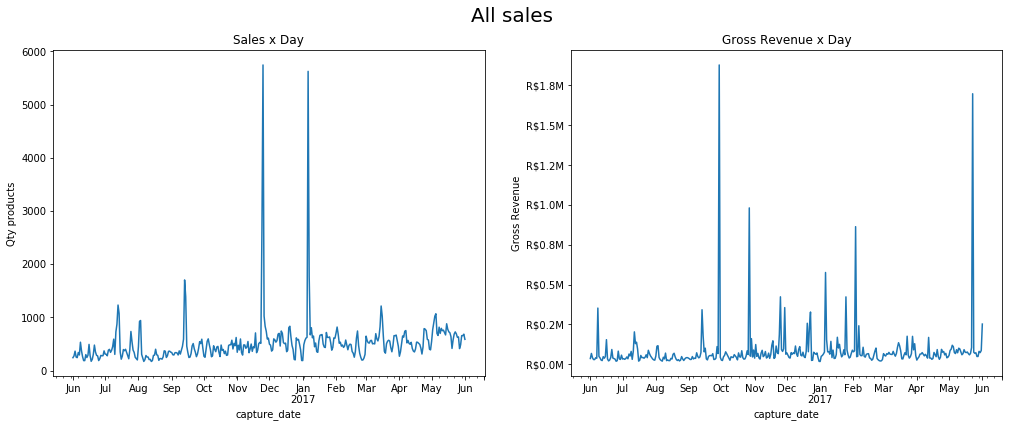

In [14]:
ts_quantity = df.groupby(pd.Grouper(key='capture_date', freq='D'))['quantity'].aggregate(np.sum)
df['gross_revenue'] = df['quantity'] * (df['price'] - df['liquid_cost'])
ts_revenue = df.groupby(pd.Grouper(key='capture_date', freq='D'))['gross_revenue'].aggregate(np.sum)

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,6))
f.suptitle("All sales", fontsize=20)
axes[0].set_title("Sales x Day")
axes[0].set_ylabel("Qty products")
ts_quantity.plot(ax=axes[0])

axes[1].set_title("Gross Revenue x Day")
axes[1].yaxis.set_major_formatter(formatter)
axes[1].set_ylabel("Gross Revenue")
ts_revenue.plot(ax=axes[1])

plt.show()

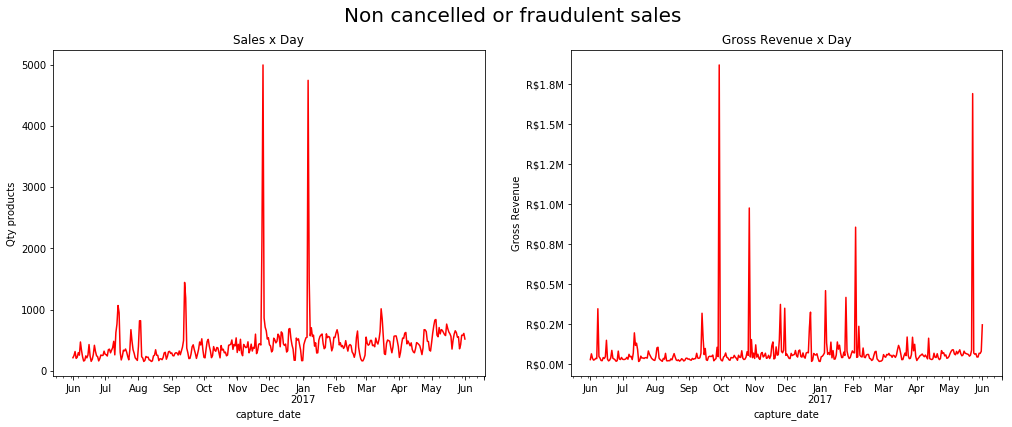

In [31]:
cancel_vals = ["cancelado boleto não pago", "cancelado", "cancelado dados divergentes", "cancelado fraude confirmada",
               "suspeita de fraude", "fraude confirmada", "cancelado não aprovado"]
filtered_df = df.copy()
filtered_df = filtered_df.loc[~df['order_status'].isin(cancel_vals)]
ts_quantity = filtered_df.groupby(pd.Grouper(key='capture_date', freq='D'))['quantity'].aggregate(np.sum)
filtered_df['gross_revenue'] = filtered_df['quantity'] * (filtered_df['price'] - filtered_df['liquid_cost'])
ts_revenue = filtered_df.groupby(pd.Grouper(key='capture_date', freq='D'))['gross_revenue'].aggregate(np.sum)

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,6))
f.suptitle("Non cancelled or fraudulent sales", fontsize=20)
axes[0].set_title("Sales x Day")
axes[0].set_ylabel("Qty products")
ts_quantity.plot(ax=axes[0], color='red')

axes[1].set_title("Gross Revenue x Day")
axes[1].yaxis.set_major_formatter(formatter)
axes[1].set_ylabel("Gross Revenue")
ts_revenue.plot(ax=axes[1], color='red')

plt.show()

### Vendas pontuais

É importante saber também se existem produtos que são comprados de forma mais pontual dentro do dataset. Para esse estudo, entenderemos o conceito de "pontual" de duas formas:

1. Produtos com uma quantidade de ordens de pedido menor que 40. 
2. Produtos com intervalo medio entre compras superior a 60 dias

A partir do código abaixo é possível identificar 6 produtos que atendem a alguma dessas características. Analisar essas compras pontuais é importante para a atividade de previsão de estoque desse projeto, uma vez que esses casos não contém histórico suficiente treinar um modelo preditivo, dessa forma, eles devem ser endereçados de forma separada. 

In [300]:
orders_threshold = 40
interval_threshold = 60
df2 = df.copy()
df2['diff_capture_date'] = df2.groupby(['code'])['capture_date'].apply(lambda x: x.diff()).dt.days
product_sales = df.groupby('code').agg({'order_id': 'nunique', 'diff_capture_date': 'mean'}).reset_index()
# product_sales = product_sales.sort_values('order_id', ascending=False)
# filtered_sales = product_sales[product_sales['order_id'] < sporadic_threshold + 200]
print("Shape: {}".format(product_sales.shape))
print("Number of sporadic purchased products (criteria 1): {}".format(product_sales[product_sales['order_id'] < 
                                                                       orders_threshold].shape))
print("Number of sporadic purchased products (criteria 2): {}" \
          .format(product_sales[product_sales['diff_capture_date'] > interval_threshold].shape))

special_df = product_sales[product_sales['order_id'] < orders_threshold]
non_special_df = product_sales[product_sales['order_id'] > orders_threshold]

product_sales.sort_values('order_id', ascending=False).tail(10)

Shape: (131, 3)
Number of sporadic purchased products (criteria 1): (6, 3)
Number of sporadic purchased products (criteria 2): (2, 3)


,code,order_id,diff_capture_date
43,41e2bee39c1d3ef52fcedd69d0ab8c8c,59,5.931034
110,c85bd735a203c905716bc8fba284d02a,58,6.350877
124,e6762ba2ffbca07ab6cee7551caeaad5,57,5.821429
105,c27a276b623c751a6b0a8ad6243d681d,51,7.140000
97,b272ba3f4adb1dd16eaac1b53940629e,31,11.666667
35,3b4407288e2983a514a241c9b84b7094,11,32.800000
71,630b051b117d509fc00a7c72328b1ddf,7,22.166667
99,b3fca69c356bec270dc3a90f8b498883,6,53.400000
23,2bc9e1d807d8f9187b8650acd35a14e5,3,156.000000
19,270dcdb08fc6470a6976f43b8169b0f6,2,245.000000


## Clusterização

Nesta seção contruiremos o cluster de produtos. O dataset utilizado neste projeto versa sobre o histórico de vendas e não apenas sobre as características dos produtos. Para montar a clusterização, é preciso que o dataset tenha unicidade por produto em cada uma das suas linhas e que as colunas versem sobre características dos mesmos. Alguns produtos tem grande variação de preço em poucos dias, bem como de impostos pagos, outros são muito mais vendidos do que outros (ex: o produto com código `270dcdb08fc6470a6976f43b8169b0f6` só foi vendido duas vezes). Outro fator interessante é que todos os produtos só pertencem a uma categoria. 

Para a clusterização, utilizaremos todos esses fatores a nosso favor na criação do dataset, usando as seguintes regras:

1. Usaremos algumas das variáveis numéricas já existentes no dataset e acrescentaremos algumas: frequência de compras, intervalo média em dias entre compras, receita bruta gerada
2. Usaremos a categoria como um atributo dos produtos
3. Usaremos o desvio padrão de preços dos produtos como uma variável categórica de três níveis: alto, médio e baixo

In [128]:
df['gross_revenue'] = df['quantity'] * (df['price'] - df['liquid_cost'])
df['diff_capture_date'] = df.groupby(['code'])['capture_date'].apply(lambda x: x.diff()).dt.days

grouped_df = df.groupby('code').agg({'quantity': 'sum', 'price': ['mean', 'std'], 'gross_revenue': 'sum',
                                    'diff_capture_date': 'mean', 'capture_date': 'max', 
                                     'order_id': 'nunique', 'category': 'min'}).reset_index()
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
# grouped_df['recency'] = (df['capture_date'].max() - grouped_df['capture_date_max']).dt.days
grouped_df['price_std_categ'] = pd.qcut(grouped_df['price_std'], 3, labels=["baixo", "medio", 'alto'])

grouped_df = grouped_df.rename(columns={'code_': 'product_id', 'gross_revenue_sum': 'gross_revenue', 
                                       'diff_capture_date_mean': 'avg_purchase_interval', 
                                        'order_id_nunique': 'purchase_frequency', 'category_min': 'category'})
grouped_df = grouped_df.drop(['price_std', 'capture_date_max'], axis=1)
cluster_dataset = grouped_df.copy()
cluster_dataset.head()

,product_id,gross_revenue,category,avg_purchase_interval,price_mean,purchase_frequency,quantity_sum,price_std_categ
0,0671c2b9132a3f5215a4212ce0691694,688589.6260,388128822cef4b4f102ae881e040a64b,0.032179,213.213890,6496,6627,medio
1,09f544ec2a74c89abeec7b0590fc2d11,136806.3076,388128822cef4b4f102ae881e040a64b,0.292733,145.200961,978,1062,alto
2,0ad316f6b5cb5e81ebff73ae2490ccfe,54443.0242,388128822cef4b4f102ae881e040a64b,0.461066,210.690798,489,499,medio
3,0bbe09e34a11e8e31cf49d6f8df2992d,32806.1189,388128822cef4b4f102ae881e040a64b,1.070588,167.754106,341,349,medio
4,0dca7ec6ba9b6e8f17f04f713a6be727,102824.5219,388128822cef4b4f102ae881e040a64b,0.254565,68.569957,932,1323,medio


### Pontos de atenção dos algoritmos de clusterização

A maioria dos algoritmos de clusterização desenvolvidos conseguem lidar ou com variáveis categóricas ou com variáveis numéricas [1]. Ao lidar com variáveis categóricas, é difícil encontrar uma função de distância que consiga representá-las adequadamente. Por exemplo, dado a variável COR pertencente ao dataset D e que pode ter os valores [vermelho, verde, azul, amarelo], é impossível dizer o quão próximo a cor vermelho está da cor azul.

Para lidar com essa questão, algumas alternativas são sugeridas na literatura científica:

1. **1-of-K Coding** [8]: consiste em transformar todas as variáveis categóricas em dummy vars. Esse método, apesar de ter resultados satisfatórios, aumenta drasticamente o número de variáveis presentes no dataset o que pode prejudicar a performance do algoritmo, também gerar overfitting (quando o cluster falha ao generalizar os agrupamentos de dados) e dificuldade na interpretação nos resultados do cluster
2. **K-prototypes** [8][9]: esse algoritmo é baseado no KMeans e no KModes. É adaptado para lidar com um mix de variáveis categóricas e contínuas, usando medidas de distância adequadas para cada um desses tipos. Os trade-offs desse método são: 

  2.1. Uma medida de distância binária é usada para as variáveis categóricas. Essa estratégia não permite capturar a real diferença entre os valores categóricos. Ex: a distância entre valores "alto" e "baixo" pode ser "maior" do que a distância entre os valores "alto" e "médio" [1]
  
  2.2. Apenas um atributo categórico é escolhido para pertencer ao centro do cluster, mesmo que os demais elementos categóricos tenham um papel importante durante o processo de clusterização [1]
  
  2.3. A implementação disponível em python [6] possui baixa performance quando o dataset tem mais de dez mil linhas
  
  
3. **_Two-step Method for Clustering Mixed numeric and categorical data_ (TMCM)** [1]: o algoritmo foi desenvolvido para conseguir lidar com variáveis categóricas e numéricas simultaneamente na clusterização. Ele é dividido em duas etapas principais: a primeira é a manipulação de variáveis categóricas de acordo com a teoria de co-ocorrência, que analisa o relacionamento entre as variáveis categóricas e gera um valor numérico razoável (e não binário) para elas; a segunda consiste na aplicação do K-means em duas etapas. Nesse estudo, foi feita a **implementação da primeira etapa do algoritmo** e o código pode ser encontrado no arquivo `tmcm_feature_engineering.py`. 

In [130]:
dataset = cluster_dataset.drop(['product_id'], axis=1)
numeric_cols = ['gross_revenue', 'avg_purchase_interval', 'price_mean', 'purchase_frequency', 
                'quantity_sum']
categ_cols = ['category', 'price_std_categ']

obj = TMCMFeatureEng(df=dataset, categ_cols=categ_cols, numeric_cols=numeric_cols)
transformed_df = obj.transform(normalize=True)
transformed_df = transformed_df.drop(categ_cols, axis=1)

### Implementação do KMeans

Um dos grandes desafios de implentar um algoritmo de clusterização é determinar qual o número ideal de clusters a ser montados. Após pesquisas realizadas, identificou-se duas formas principais de lidar com essa situação:

1. **Análise de silhueta** [5]: pode ser compreendida como o estudo da distância de separação entre os clusters resultantes do KMeans. O gráfico de silhueta exibe uma medida de quão próximo cada ponto em um cluster é para pontos nos clusters vizinhos e, portanto, fornece uma maneira de avaliar visualmente os parâmetros como número de clusters. Uma medida numérica utilizada é a average silhouette, que é a média dos valores das silhuetas dos clusters. Quanto maior o valor da average silhouette melhor o cluster.

2. **Método do cotovelo** [4]: este método analisa a porcentagem de variância explicada como uma função do número de clusters: é preciso escolher uma série de clusters para que a adição de outro cluster não ofereça muito melhor modelagem dos dados. Mais precisamente, se uma parcela a porcentagem de variância explicada pelos clusters em relação ao número de clusters, os primeiros clusters adicionarão muita informação (explicam muita variância), mas em algum momento o ganho marginal cairá, dando um ângulo na gráfico.

Neste estudo utilizaremos o segundo método para identificação do melhor valor de k para o KMeans. A partir da implementação abaixo, é possível ver que o melhor valor para K é 4. Usaremos k=4 para treinar a versão final da clusterização

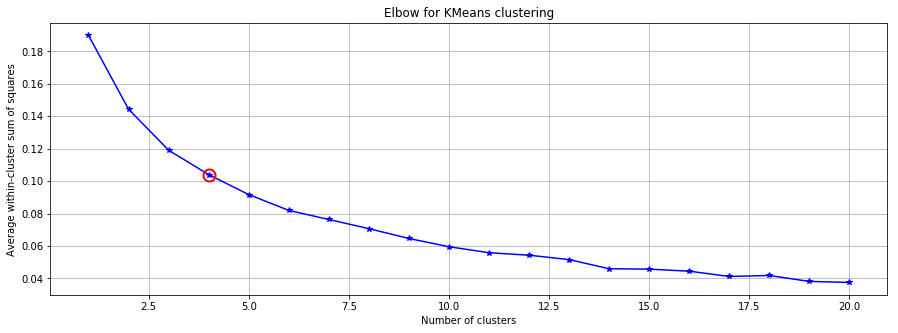

In [131]:
plot_elbow_curve(transformed_df, range(1,21))

In [132]:
kmeans = KMeans(init='k-means++', n_clusters=4, random_state=40).fit(transformed_df)
labels = kmeans.labels_
cluster_dataset['cluster'] = labels
cluster_dataset[cluster_dataset['cluster'] == 2].head()

,product_id,gross_revenue,category,avg_purchase_interval,price_mean,purchase_frequency,quantity_sum,price_std_categ,cluster
1,09f544ec2a74c89abeec7b0590fc2d11,136806.3076,388128822cef4b4f102ae881e040a64b,0.292733,145.200961,978,1062,alto,2
2,0ad316f6b5cb5e81ebff73ae2490ccfe,54443.0242,388128822cef4b4f102ae881e040a64b,0.461066,210.690798,489,499,medio,2
3,0bbe09e34a11e8e31cf49d6f8df2992d,32806.1189,388128822cef4b4f102ae881e040a64b,1.070588,167.754106,341,349,medio,2
4,0dca7ec6ba9b6e8f17f04f713a6be727,102824.5219,388128822cef4b4f102ae881e040a64b,0.254565,68.569957,932,1323,medio,2
5,0f38be2df6854b4374f06cae1bc38482,237030.7980,388128822cef4b4f102ae881e040a64b,0.096254,214.635592,2110,2166,medio,2


### Análise dos clusters

Para analisar as características que definem cada um dos clusters é preciso compará-los a partir de seus atributos assim como entender como esses atributos se posicionam acima ou abaixo da média do entre todos os clusters. Na função desenvolvida abaixo, os gráficos comparativos de cada atributo nos clusters são apresentados na tela e a linha horizontal vermelha representa a média dos respectivos atributos. Baseado neles, vemos que:

* **Cluster 0**: segundo menor cluster em quantidade de produtos, não tem uma diversidade muito grande de categoria de produtos, mas são produtos que geram uma receita bruta muito alta, que são comprados com frequência e e totalizam uma grande quantidade comprada. Um fator interessante sobre ele é que ele contém os produtos com preço médio mais barato entre todos. Em termos de variabilidade nos preços dos produtos, esse cluster contém quantidade praticamente semelhante de cada um dos tipos.
* **Cluster 1**: é um cluster intermediário ente o 0 e o 2. Tem receita bruta acima da média, mas não contém produtos que são comprados com frequência, mesmo que seus preços sejam abaixo da média. É um cluster que tem contém produtos cuja maior variação de preços é "alta"
* **Cluster 2**: é o cluster do sortimento de produtos, tendo em vista que ele contém a maior quantidade de itens e também a maior diversidade de categorias dentro de si. Contém produtos com o maior preço médio mas com receita bruta abaixo da média. Eles também não possuem uma frequência de compras muito elevada. 
* **Cluster 3**: só contém produtos de uma categoria e cuja variabilidade de preços é mediana. Trazem pouca receita bruta, são comprados pouca frequência, mas se destacam por ter a segunda maior média de preços

In [139]:
def display_cluster(df):
    df['prod_per_purch'] = df['quantity_sum'] / df['purchase_frequency']
    df_general = df.groupby('cluster').agg({'gross_revenue': 'mean', 'quantity_sum': 'mean',
                                            'product_id': 'size', 'category': 'nunique',
                                           'purchase_frequency': 'mean', 'prod_per_purch': 'mean',
                                           'price_mean': 'mean'}).reset_index()
    df_price_levels = df.groupby(['cluster', 'price_std_categ']).agg({'product_id': 'size'}).reset_index()
    df_price_levels = pd.pivot_table(df_price_levels,  values='product_id',  columns=['price_std_categ'],  
                                     index = "cluster", aggfunc=np.sum,  fill_value=0)
    
    print("Media de produtos adquiridos por compra:")
    for index, row in df_general.iterrows():
        print("Cluster {}: {:.2f}".format(row['cluster'], row['prod_per_purch']))
    
    f, axes = plt.subplots(nrows=3, ncols=3, figsize=(17,15))

    axes[0][0].set_title("Comparison among clusters sizes")
    axes[0][0].set_ylabel("Cluster size")
    axes[0][0].axhline(df_general['product_id'].mean(), color='red')
    df_general.plot.bar(x='cluster', y='product_id', ax=axes[0][0], color='green')
    
    axes[0][1].set_title("Comparison among gross revenue mean in clusters")
    axes[0][1].set_ylabel("Mean of gross revenue")
    axes[0][1].yaxis.set_major_formatter(t_formatter)
    axes[0][1].axhline(df_general['gross_revenue'].mean(), color='red')
    df_general.plot.bar(x='cluster', y='gross_revenue', ax=axes[0][1], color='green')
    
    axes[0][2].set_title("Comparison among quantity mean in clusters")
    axes[0][2].set_ylabel("Mean of quantity")
    axes[0][2].axhline(df_general['quantity_sum'].mean(), color='red')
    df_general.plot.bar(x='cluster', y='quantity_sum', ax=axes[0][2], color='green')
    
    axes[1][0].set_title("Comparison among count of categories in clusters")
    axes[1][0].set_ylabel("Count")
    axes[1][0].axhline(df_general['category'].mean(), color='red')
    df_general.plot.bar(x='cluster', y='category', ax=axes[1][0], color='green')
    
    axes[1][1].set_title("Comparison among purchase frequencies mean in clusters")
    axes[1][1].set_ylabel("Purchase frequency")
    axes[1][1].axhline(df_general['purchase_frequency'].mean(), color='red')
    df_general.plot.bar(x='cluster', y='purchase_frequency', ax=axes[1][1], color='green')
    
    axes[1][2].set_title("Comparison among price mean in clusters")
    axes[1][2].set_ylabel("Price mean")
    axes[1][2].axhline(df_general['price_mean'].mean(), color='red')
    df_general.plot.bar(x='cluster', y='price_mean', ax=axes[1][2], color='green')
    
    axes[2][0].set_title("Comparison of price variation among clusters")
    axes[2][0].set_ylabel("Count of price variation level")
    df_price_levels.plot.bar(ax=axes[2][0])


    plt.show()

Media de produtos adquiridos por compra:
Cluster 0.0: 1.05
Cluster 1.0: 1.12
Cluster 2.0: 1.05
Cluster 3.0: 1.04


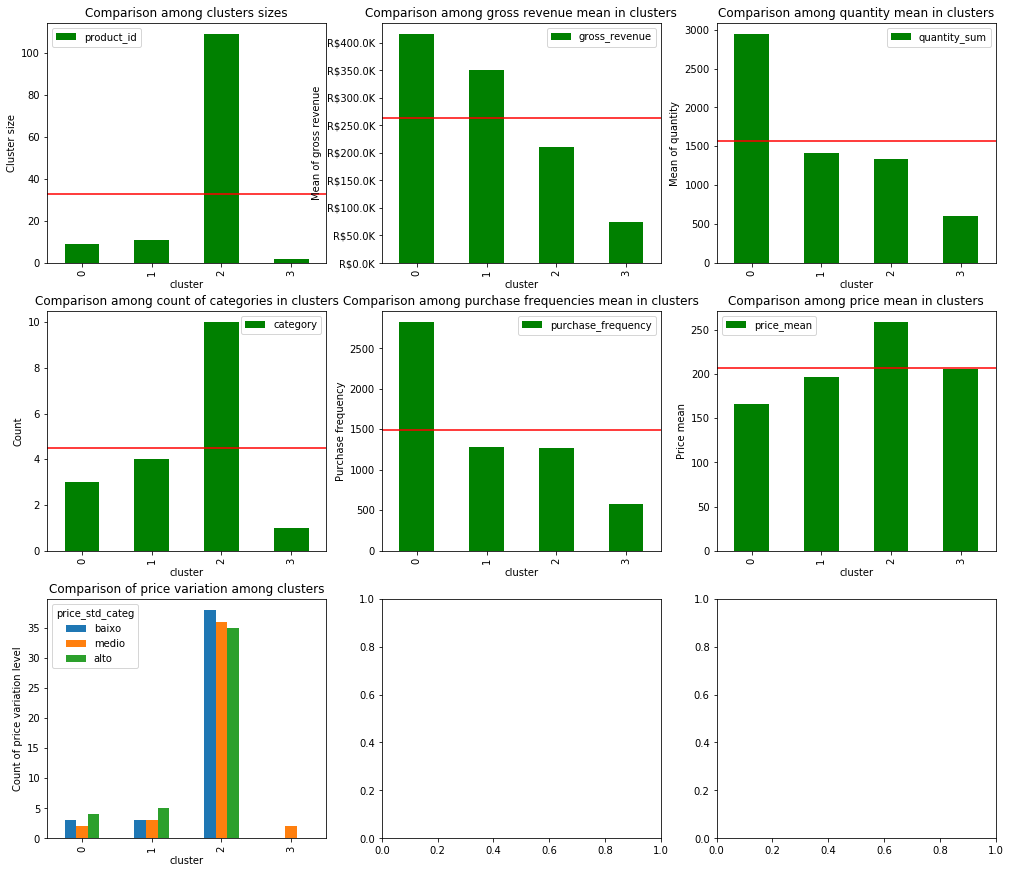

In [140]:
display_cluster(cluster_dataset)

## Previsão de estoque

O desafio de predizer as vendas dos meses de junho, julho e agosto de 2017 pode ser compreendido como _Timeseries Forecasting_. Para resolver esse tipo de problema, é possível utilizar modelos estatísticos, econométricos ou modelos de machine learning [7]. Para lidar com esse desafio, precisamos quebrar nossa abordagem em duas partes principais:

1. Produtos pontuais: esses produtos são bem difíceis de prever, dado seu histórico pequeno de compras. É difícil identificar os elementos de tendência e sazonalidade presentes nas séries temporais nesses casos. Dessa forma, usaremos a técnica de _exponential smoothing_
2. Demais produtos: nesses casos temos uma amostra maior de histórico de compras e será mais fácil usar modelos que lidam com sazonalidades e tendências. Aqui, serão comparados dois modelos, _exponential smoothing_ e ARIMA para averiguar qual deles tem uma performance melhor na predição.

Todos os modelos serão avaliados e comparados usando a métrica RMSE. 

### Tratamento dos dados

Para realizar a predição dos dados, faremos a agregação dos dados pelo conjunto `ano-mês`. Dado isso, é importante notar que nem todos os produtos possuem histórico de compra em todos os meses, mesmo aqueles que não são pontuais. Dado isso, faremos o preenchimento dos meses faltantes com o valor zero. As funções abaixo fazem esse preenchimento e também criam a série temporal para determinado produto.

In [279]:
def fill_series(ts, start, end):
    start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in [start, end]]
    total_months = lambda dt: dt.month + 12 * dt.year
    mlist = []
    for tot_m in xrange(total_months(start)-1, total_months(end)):
        y, m = divmod(tot_m, 12)
        mlist.append(datetime(y, m+1, 1).strftime("%Y-%m-01"))
    
    diff = list(set(mlist) - set(ts.index))
    for i in diff: 
        ts = ts.append(pd.Series(0, index=[i]))
        ts = ts.sort_index()
    return(ts)

def create_timeseries(df, product_id, index_col='ym'):
    df2 = df.copy()
    df2['ym'] = df2['capture_date'].apply(lambda x: x.strftime('%Y-%m-01'))
    g = df2.groupby(['ym', 'code']).agg({'quantity': 'sum'}).reset_index()
    aux = g[g['code'] == product_id]
    ts = aux['quantity'].copy()
    ts.index = aux[index_col]
    start = aux[index_col].min()
    end = aux[index_col].max()
    ts = fill_series(ts, start, end)
    return(ts)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ts = create_timeseries(df, "e6762ba2ffbca07ab6cee7551caeaad5")

### Aplicação e avaliação dos modelos

Nesta seção, aplicaremos os modelos seguindo as regras descritas acima. Como temos uma variedade muito grande de produtos não pontuais, é difícil calibrar o modelo do ARIMA com valores fixos para `p`, `q` e `d` e fazer esse trabalho manualmente também seria muito custoso. Dado isso, usaremos a estratégia de _grid search_[2] para definir as melhores combinações de parâmetros possível para cada produto. 

O mês mais atual de do histórico de cada produto será usado como dado de teste e todos os meses anteriores serão usados como dados de treino. 

In [383]:
# EXPONENTIAL SMOOTHING
def apply_exp_smoothing(ts):
    y_true = ts[-1]
    ts_train = ts[:-1]
    obj = {}
    try:
        fit = SimpleExpSmoothing(ts_train).fit(smoothing_level=0.6,optimized=False)
        y_hat = fit.forecast()
        obj['y_true'] = y_true
        obj['y_hat'] = y_hat
        obj['mape'] = mean_absolute_percentage_error(y_true, y_hat)
        obj['rmse'] = math.sqrt(mean_squared_error([y_true], [y_hat]))
    except:
        obj['y_true'] = np.nan
        obj['y_hat'] = np.nan
        obj['mape'] = np.nan
        obj['rmse'] = np.nan
    return(obj)

# ARIMA
def evaluate_arima_model(X, arima_order):
    size = -1
    train, test = X[:size], [X[size]]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
#         print('predicted=%f, expected=%f' % (yhat, obs))
    mse = mean_squared_error(test, predictions)
    rmse = math.sqrt(mse)
    return(rmse)

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
#                     print('ARIMA%s RMSE=%.3f' % (order,mse))
                except NameError as e:
                    print e
                    continue
                except ValueError as e:
                    print e
                    continue
                except:
                    print "Unexpected error:", sys.exc_info()[0]
                    continue
#     print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return(best_cfg)

def apply_arima(ts):
    obj = {}
    # evaluate parameters
    p_values = range(0, 2)
    d_values = range(0, 2)
    q_values = range(0, 2)
    arima_cfg = evaluate_models(ts, p_values, d_values, q_values)
    
    ts = ts.astype('float32')
    y_true = ts[-1]
    ts_train = ts[:-1]
    model = ARIMA(ts_train, order=arima_cfg)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    y_hat = output[0]
    obj['y_true'] = y_true
    obj['y_hat'] = y_hat
    obj['mape'] = mean_absolute_percentage_error(y_true, y_hat)
    obj['rmse'] = math.sqrt(mean_squared_error([y_true], [y_hat]))
    return(obj)

#### Produtos pontuais

De acordo com a execução do código abaixo, a aplicação do modelo _exponential smoothing_ para uma série temporal para a qual não existe um histórico de dados tão grande apresentou um RMSE médio de 71%. É um erro muito elevado, mas ainda sim menor do que os erros obtidos aplicando a técnica de médias móveis (erro de 75%). Esse modelo preditivo não parece ser o mais adequado para essas circunstâncias. 


In [384]:
product_ids = special_df['code'].unique().tolist()
err = []
for pid in product_ids:
    ts = create_timeseries(df, pid)
    a = apply_exp_smoothing(ts)
#     print(a['y_true'], a['y_hat'])
    if not np.isnan(a['rmse']):
        err.append(a['rmse'])
    
np.mean(err)

0.7103068706133332

#### Demais produtos

A execução do código abaixo monta um dataframe que contém o produto, o erro obtido pela execução do _exponential smoothing_ e o erro obtido pela execução do ARIMA. De maneira geral não temos um comportamento padrão dos modelos em relação a todos os produtos de forma a otimizar a predição realizada. Isso pode ser visto, por exemplo, ao pegarmos o menor e o maior valor de erro para o ARIMA, que são respectivamente 0.08 e 1775.53. Dessa forma, não é possível dizer qual dos dois modelos performa melhor, de maneira geral. Sendo assim, a melhor forma de fazer predição de estoque para cada produto é selecionando o modelo com o menor erro possível para cada produto.  

Durante a fase de treinamento do ARIMA também observou-se que para alguns produtos certos valores de `p`, `q` e `d` não se aplicavam, provavelmente porque o produto não tinha histórico de dados o suficiente para justificar o uso do ARIMA, que precisa de uma quantidade significativa de pontos para ter uma boa performance. 

In [397]:
product_ids = non_special_df['code'].unique().tolist()
 
objs = []
for pid in product_ids:
    ts = create_timeseries(df, pid)
    a = apply_exp_smoothing(ts)
    b = apply_arima(ts)
    objs.append({'product_id': pid, 'err_exp_sm': a['rmse'], 'err_arima': b['rmse']})
    

In [394]:
results_df = pd.DataFrame(objs)

### Predição para os meses de junho, julho e agosto

A predição para esses meses acontecerá da seguinte forma:

1. Considere que o produto X possui histórico de vendas até o mês M
2. O modelo preditivo (seja ele para os produtos pontuais, seja para os demais) vai prever dados para M+1
3. A previsão para M+1 é adicionada ao dataset de treino e o modelo preditivo é treinado novamente
4. Repetem-se os passos 2 e 3 até que se tenha as previsões para os meses de junho, julho e agosto

Vale a ressalva de que, quanto mais distante for M dos meses de junho, julho e agosto, maior a chance do nosso modelo errar a previsão de estoque, pois ele fará predições de dados em cima de outros dados preditos, o que acarreta pode acarretar na propagação e aumento do erro cometido pelo modelo. 

## Conclusões

Neste projeto foram implementados um modelo de clusterização de produtos e dois modelos de séries temporais para previsão de estoque de produtos. 

No primeiro, usamos uma técnica baseada na teoria de co-ocorrência para criar valores numéricos apropriados para _features_ categóricas do dataset e depois aplicamos o K-Means para realizar a clusterização dos produtos e utilizamos a técnica do cotovelo para definir o melhor valor de K

No segundo, identificamos dois tipos principais de produtos, aqueles que tem uma demanda elevada, ou seja, são comprados com uma certa frequência e aqueles que tem demandas pontuais, ou seja, para os quais não existe um grande histórico de compras. Para o primeiro grupo de produtos, testamos dois modelos, o _exponential smoothing_ e o ARIMA. Para o segundo grupo, testamos apenas o modelo de _exponential smoothing_. 

Como pontos de evolução no projeto, vislumbro os seguintes itens:

**Cluster**

1. Usar a taxa de cancelamento e de fraude como atributo do dataset
2. Explorar o atributo recência de compra para a clusterização
3. Implementar por completo o algoritmo TMCM

**Predição de estoque**

1. Tentar ajustar o modelo para lidar com datas especiais conforme descrito em [3]
2. Aplicar modelos de machine learning para realizar a previsão de estoque de tal modo que as características de cada cluster sejam utilizadas pelo modelo. 

## Referências

[1] A Two-Step Method for Clustering Mixed Categroical and Numeric Data

[2] Time Series Forecast Study with Python: Monthly Sales of French Champagne. (2017, March 30). Retrieved from https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

[3] Catal, C., Fenerci, A., Ozdemir, B., & Gulmez, O. (2015). Improvement of Demand Forecasting Models with Special Days. Procedia Computer Science, 59, 262-267. doi:10.1016/j.procs.2015.07.554

[4] Elbow method (clustering). (2016, May 29). Retrieved from https://en.wikipedia.org/wiki/Elbow_method_(clustering)

[5] Selecting the number of clusters with silhouette analysis on KMeans clustering — scikit-learn 0.19.2 
documentation. (n.d.). Retrieved August 16, 2018, from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

[6] nicodv/kmodes. (n.d.). Retrieved from https://github.com/nicodv/kmodes

[7] Bontempi G., Ben Taieb S., Le Borgne YA. (2013) Machine Learning Strategies for Time Series Forecasting. In: Aufaure MA., Zimányi E. (eds) Business Intelligence. eBISS 2012. Lecture Notes in Business Information Processing, vol 138. Springer, Berlin, Heidelberg

[8] Wang, Fei & Franco, Hector & Pugh, John & Ross, Robert. (2016). Empirical Comparative Analysis of 1-of-K Coding and K-Prototypes in Categorical Clustering.

[9] Huang, Z.: Clustering large data sets with mixed numeric and categorical values, Proceedings of the First Pacific Asia Knowledge Discovery and Data Mining Conference, Singapore, pp. 21-34, 1997.